In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
from scipy.sparse import csr_matrix

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Dataset/fer2013_new.csv')
df.head()

,emotion,pixels,Usage
0,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
1,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training
2,2,55 55 55 55 55 54 60 68 54 85 151 163 170 179 ...,Training
3,4,20 17 19 21 25 38 42 42 46 54 56 62 63 66 82 1...,Training
4,3,77 78 79 79 78 75 60 55 47 48 58 73 77 79 57 5...,Training


In [ ]:
emotion_labels = {0:'anger', 1:'disgust', 2:'fear', 3:'happiness', 4: 'sadness', 5: 'surprise', 6: 'neutral'}
Labels = [2,3,4,6]
df = df[df.emotion.isin(Labels)]

In [ ]:
df['emotion'].value_counts()

3    7599
6    5440
4    4521
2    3921
Name: emotion, dtype: int64

In [ ]:
img_array = df.pixels.apply(lambda x: np.array(x.split(' ')).reshape(48, 48, 1).astype('float32'))
img_array = np.stack(img_array, axis=0)
img_array.shape

(21481, 48, 48, 1)

In [ ]:
LE = LabelEncoder()
img_labels = LE.fit_transform(df['emotion'])
img_labels = np_utils.to_categorical(img_labels)
img_labels.shape

(21481, 4)

In [ ]:
LE_label_mapping = dict(zip(LE.classes_, LE.transform(LE.classes_)))
LE_label_mapping

{2: 0, 3: 1, 4: 2, 6: 3}

In [ ]:
from sklearn.model_selection import train_test_split
Xtrain, Xtest,y_train, y_test = train_test_split(img_array, img_labels,
                                                    shuffle=True, stratify=img_labels,
                                                    test_size=0.20, random_state=42)

In [ ]:
Xtrain.shape, Xtest.shape,y_train.shape, y_test.shape

((17184, 48, 48, 1), (4297, 48, 48, 1), (17184, 4), (4297, 4))

In [ ]:
Xt, Xval, yt, yval = train_test_split(Xtrain, y_train, shuffle=True, test_size=0.20, random_state=42)

In [ ]:
Xt.shape, Xval.shape, yt.shape

((13747, 48, 48, 1), (3437, 48, 48, 1), (13747, 4))

In [ ]:
!pip install mtcnn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 48.1 MB/s eta 0:00:00


In [ ]:
img_array[0].shape

(48, 48, 1)

In [ ]:
import cv2
import dlib
import networkx as nx
from scipy.sparse import csr_matrix

In [ ]:
from keras.models import load_model
from tensorflow.keras.models import Model
cnn_model = load_model('/content/drive/MyDrive/Dataset/emote_model (1).h5')
model_cnn = Model(inputs=cnn_model.input, outputs=cnn_model.get_layer('conv2d_6').output)

In [ ]:
from google.colab.patches import cv2_imshow
from scipy.spatial import cKDTree
from sklearn.metrics.pairwise import pairwise_distances
from mtcnn import MTCNN

In [ ]:
predictor = dlib.shape_predictor('/content/drive/MyDrive/Dataset/shape_predictor_68_face_landmarks (1) (1).dat')
landmark_indices = [37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67]

def extract_features(img_array , predictor, labels, landmark_indices, batch_size):
    num_batches = (len(img_array) + batch_size-1) // batch_size
    print("Number of Batches: ", num_batches)
    detector = MTCNN()

    for i in range(62, num_batches):
        print(i)
        batch_adj = []
        batch_feat = []
        batch_labels = labels[i*batch_size:(i+1)*batch_size]

        for img in img_array[i*batch_size:(i+1)*batch_size]:
          gray = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
          gray = np.array(gray)
          #gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
          gray = cv2.convertScaleAbs(gray)
          #detector = dlib.get_frontal_face_detector()
          #rects = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=4)
          rects = detector.detect_faces(gray)

          if len(rects) == 0:
            # Preprocess the image or print a message indicating that no faces were detected
            print("No faces were detected in the image.")
            batch_adj.append(np.zeros((31,31)))
            batch_feat.append(np.zeros((31, 36864)))
            continue
          
          print("Rectangles: ", rects)

          landmarks = []
          for rect in rects:
            x,y,w,h = rect['box']
            dlib_rect = dlib.rectangle(x, y, x+w, y+h)
            full_landmarks = predictor(gray, dlib_rect)
            subset_landmarks = []

            for j in landmark_indices:
              if j < full_landmarks.num_parts:
                x = full_landmarks.part(j).x
                y = full_landmarks.part(j).y
                subset_landmarks.append(dlib.point(x, y))
            landmarks.append(dlib.full_object_detection(dlib_rect, dlib.points(subset_landmarks)))
          
          features = []
          for landmark in landmarks:
            for k in range(31):
              x, y = landmark.part(k).x, landmark.part(k).y  # Get the (x,y) coordinates of the landmark
              patch = gray[y-12:y+12, x-12:x+12]  # Extract a  patch around the landmark
              if patch.size == 0:
                patch = gray[y-4:y+4, x-4:x+4]
                if patch.size == 0:
                  print("3")
                  patch = gray[y-3:y+3, x-3:x+3]
                  if patch.size == 0:
                    print("2")
                    patch = gray[y-2:y+2, x-2:x+2]
              patch = cv2.resize(patch, (48, 48))  # Resize the patch to the input size of the CNN model
              patch = cv2.cvtColor(patch, cv2.COLOR_BGR2GRAY)  # Convert the patch to grayscale
              patch = np.expand_dims(patch, axis=-1)
              patch = np.expand_dims(patch, axis=0)
              feature = model_cnn.predict(patch, verbose=0)  # Extract features from the patch using the CNN model
              features.append(feature)
            break
          node_embeddings = features[0]
          for l in range(1, len(features)):
            node_embeddings = np.concatenate((node_embeddings, features[l]), axis=0)

          num_nodes, height, width, channels = node_embeddings.shape
          flat_node_embeddings = node_embeddings.reshape(num_nodes, height * width * channels)

          batch_feat.append(flat_node_embeddings)

          distances = pairwise_distances(flat_node_embeddings, metric='euclidean')
          mean_distance = np.mean(distances)
          max_dist = 1.15 * mean_distance

          kdtree = cKDTree(flat_node_embeddings)

          graph = nx.Graph()

          for m in range(len(node_embeddings)):
            graph.add_node(m, feature=node_embeddings[m])

          for a in range(len(node_embeddings)):
          # Find the nearest neighbors to the current node within max_dist
            indices = kdtree.query_ball_point(flat_node_embeddings[a].reshape(1, -1), r=max_dist, p=2)[0]
            for b in indices:
              # Add an edge between the two nodes if they are close enough and not already connected
              if a != b and b < len(features) and not graph.has_edge(a, b) and distances[a, b] <= max_dist:
                graph.add_edge(a, b, weight=distances[a, b])

          A = nx.to_numpy_array(graph)

          A = A + np.eye(A.shape[0])
          D = np.sum(A, axis=1)
          D_sqrt_inv = np.power(D, -0.5)
          D_sqrt_inv[np.isinf(D_sqrt_inv)] = 0.
          D_sqrt_inv = np.diag(D_sqrt_inv)
          A_norm = D_sqrt_inv @ A @ D_sqrt_inv
          batch_adj.append(A_norm)
        batch_adj = np.stack(batch_adj, axis=0)
        batch_feat = np.stack(batch_feat, axis=0)
        print("Adjacency Batch Shape is: ", batch_adj.shape)
        print("Feature Batch Shape is: " , batch_feat.shape)
        print("Batch Labels shape is: ", batch_labels.shape)
        np.savez_compressed(f'/content/drive/MyDrive/matrices/val/batch_data_{i}.npz', batch_adj=batch_adj, batch_feat=batch_feat, batch_labels=batch_labels)
        del batch_feat, batch_adj, batch_labels, node_embeddings, features, landmarks, A_norm, A, graph, flat_node_embeddings, distances, kdtree, subset_landmarks, rects, gray, D,D_sqrt_inv, indices, patch, full_landmarks

In [ ]:
data = np.load('batch_data.npz')

# Extract the arrays from the npz file
batch_adj = data['batch_adj']
batch_feat = data['batch_feat']
batch_labels = data['batch_labels']

batch_adj.shape

(32, 31, 31)

In [ ]:
extract_features(Xval , predictor, yval, landmark_indices, 32)

Number of Batches:  108
62
1/1 [==============================] - 0s 476ms/step
Rectangles:  [{'box': [4, 2, 40, 47], 'confidence': 0.999981164932251, 'keypoints': {'left_eye': (15, 19), 'right_eye': (33, 18), 'nose': (25, 29), 'mouth_left': (18, 39), 'mouth_right': (34, 37)}}]


1/1 [==============================] - 0s 61ms/step
Rectangles:  [{'box': [1, 0, 45, 54], 'confidence': 0.9992923736572266, 'keypoints': {'left_eye': (15, 16), 'right_eye': (35, 21), 'nose': (21, 33), 'mouth_left': (11, 40), 'mouth_right': (27, 44)}}]
1/1 [==============================] - 0s 36ms/step
Rectangles:  [{'box': [5, 0, 48, 62], 'confidence': 0.9905941486358643, 'keypoints': {'left_eye': (14, 18), 'right_eye': (37, 17), 'nose': (20, 31), 'mouth_left': (16, 45), 'mouth_right': (34, 44)}}]
1/1 [==============================] - 0s 30ms/step
Rectangles:  [{'box': [3, 0, 42, 54], 'confidence': 0.9985929131507874, 'keypoints': {'left_eye': (15, 19), 'right_eye': (34, 21), 'nose': (23, 30), 'mouth_left': (14, 41), 'mouth_right': (30, 43)}}]
1/1 [==============================] - 0s 46ms/step
Rectangles:  [{'box': [2, 2, 39, 47], 'confidence': 0.9999287128448486, 'keypoints': {'left_eye': (15, 19), 'right_eye': (33, 20), 'nose': (23, 29), 'mouth_left': (16, 38), 'mouth_right': (30,

KeyboardInterrupt: ignored

In [ ]:
model_cnn.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1_input (InputLayer)  [(None, 48, 48, 1)]      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 256)       6656      
                                                                 
 batchnorm_1 (BatchNormaliza  (None, 48, 48, 256)      1024      
 tion)                                                           
                                                                 
 conv2d_2 (Conv2D)           (None, 48, 48, 128)       819328    
                                                                 
 batchnorm_2 (BatchNormaliza  (None, 48, 48, 128)      512       
 tion)                                                           
                                                                 
 maxpool2d_1 (MaxPooling2D)  (None, 24, 24, 128)       0     

In [ ]:
"""
    for i in range(len(features)):
      # Find the nearest neighbors to the current node within max_dist
      indices = kdtree.query_radius(flat_node_embeddings[i].reshape(1, -1), r=max_dist)[0]
      for j in indices:
        # Add an edge between the two nodes if they are close enough and not already connected
        if i != j and j < len(features) and not graph.has_edge(i, j):
          graph.add_edge(i, j, weight=max_dist)
"""

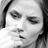

In [ ]:
from google.colab.patches import cv2_imshow
img = cv2.cvtColor(img_array[0], cv2.COLOR_GRAY2BGR)
cv2_imshow(img)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
adj = extract_features(img_array[10] , predictor, landmark_indices)

TypeError: ignored

In [ ]:
import tensorflow as tf
import spektral
from spektral.utils import sp_matrix_to_sp_tensor
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Flatten, Dense, Lambda
from tensorflow.keras.layers import Dropout, BatchNormalization, Activation
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input
from keras.models import Model
from keras.regularizers import l2

In [ ]:
X_in = Input(shape = (31,36864))
A_in = Input(shape = (31, 31))
l2_reg = 5e-4 

GCN1 = spektral.layers.GCNConv(channels = 512, activation='elu', kernel_initializer='he_normal', name='GCN1')([X_in,A_in])
B1 = BatchNormalization()(GCN1)
GCN2 = spektral.layers.GCNConv(channels = 256, activation='elu', kernel_initializer='he_normal', name='GCN2')([B1, A_in])
B2 = BatchNormalization()(GCN2)
D1 = Dropout(0.5)(B2)
GCN3 = spektral.layers.GCNConv(channels = 256, activation='elu', kernel_initializer='he_normal', name='GCN3')([D1,A_in])
B3 = BatchNormalization()(GCN3)
GCN4 = spektral.layers.GCNConv(channels = 128 ,activation='elu', kernel_initializer='he_normal', name='GCN4')([B3, A_in])
B4 = BatchNormalization()(GCN4)
D2 = Dropout(0.5)(B4)
GCN5 = spektral.layers.GCNConv(channels = 128 ,activation='elu', kernel_initializer='he_normal', name='GCN5')([D2, A_in])
B5 = BatchNormalization()(GCN5)
GCN6 = spektral.layers.GCNConv(channels = 64 ,activation='elu', kernel_initializer='he_normal',name='GCN6')([B5, A_in])
B6 = BatchNormalization()(GCN6)
MP1 = spektral.layers.GlobalMaxPool()(B6)
D3 = Dropout(0.5)(MP1)
flatten = Flatten()(D3)
DS1 = Dense(64 ,activation='elu',kernel_initializer='he_normal')(flatten)
B7 = BatchNormalization()(DS1)
DS2 = Dense(32 ,activation='elu',kernel_initializer='he_normal')(B7)
B8 = BatchNormalization()(DS2)
D3 = Dropout(0.6)(B8)
output = Dense(4 , activation='softmax')(D3)

model = Model(inputs=[X_in, A_in], outputs=output)

In [ ]:
from tensorflow.keras.optimizers import Adam
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 31, 36864)]  0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 31, 31)]     0           []                               
                                                                                                  
 GCN1 (GCNConv)                 (None, 31, 512)      18874880    ['input_1[0][0]',                
                                                                  'input_2[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 31, 512)     2048        ['GCN1[0][0]']               

In [ ]:
X_in = Input(shape = (51, 18432))
A_in = Input(shape = (51, 51))
l2_reg = 5e-4

GCN1 = spektral.layers.GCNConv(channels = 128, activation='elu', kernel_initializer='he_normal', name='GCN1')([X_in,A_in])
B1 = BatchNormalization()(GCN1)
GCN2 = spektral.layers.GCNConv(channels = 128, activation='elu', kernel_initializer='he_normal', name='GCN2')([B1, A_in])
B2 = BatchNormalization()(GCN2)
D1 = Dropout(0.4)(B2)
GCN3 = spektral.layers.GCNConv(channels = 256, activation='elu', kernel_initializer='he_normal', name='GCN3')([D1,A_in])
B3 = BatchNormalization()(GCN3)
GCN4 = spektral.layers.GCNConv(channels = 256 ,activation='elu', kernel_initializer='he_normal', name='GCN4')([B3, A_in])
B4 = BatchNormalization()(GCN4)
D2 = Dropout(0.4)(B4)
GCN5 = spektral.layers.GCNConv(channels = 512,activation='elu', kernel_initializer='he_normal', name='GCN5')([D2, A_in])
B5 = BatchNormalization()(GCN5)
GCN6 = spektral.layers.GCNConv(channels = 512 ,activation='elu', kernel_initializer='he_normal',name='GCN6')([B5, A_in])
B6 = BatchNormalization()(GCN6)
MP1 = spektral.layers.GlobalMaxPool()(B6)
D3 = Dropout(0.4)(MP1)
flatten = Flatten()(D3)
DS1 = Dense(128 ,activation='elu',kernel_initializer='he_normal')(flatten)
B7 = BatchNormalization()(DS1)
DS2 = Dense(32 ,activation='elu',kernel_initializer='he_normal')(B7)
B8 = BatchNormalization()(DS2)
D4 = Dropout(0.4)(B8)
output = Dense(4, activation='softmax')(D4)

model = Model(inputs=[X_in, A_in], outputs=output)

In [ ]:
early_stopping = EarlyStopping(monitor='val_accuracy',min_delta=0.00005,patience=10,verbose=1,
    restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_accuracy',factor=0.5,patience=7,min_lr=1e-7,verbose=1)

callbacks = [early_stopping,lr_scheduler]

In [ ]:
train = [f'/content/drive/MyDrive/matrices/train/batch_data_{i}.npz' for i in range(430)]
val = [f'/content/drive/MyDrive/matrices/val/batch_data_{j}.npz' for j in range(108)]

In [ ]:
import random
def train_gen():
    num_batches = 430
    print("Number of Batches: ", num_batches)

    batch_indices = list(range(num_batches))

    while True:
      random.shuffle(batch_indices)

      for k in batch_indices:
        data = np.load(f'/content/drive/MyDrive/matrices/train/batch_data_{k}.npz')
        batch_adj = data['batch_adj']
        batch_feat = data['batch_feat']
        batch_labels = data['batch_labels']

        yield (batch_feat, batch_adj), batch_labels
        del batch_feat, batch_adj, batch_labels

In [ ]:
def val_gen():
    num_batches = 108
    print("Number of Batches: ", num_batches)

    batch_indices = list(range(num_batches))

    while True:
      random.shuffle(batch_indices)

      for k in batch_indices:
        data = np.load(f'/content/drive/MyDrive/matrices/val/batch_data_{k}.npz')
        batch_adj = data['batch_adj']
        batch_feat = data['batch_feat']
        batch_labels = data['batch_labels']

        yield (batch_feat, batch_adj), batch_labels
        del batch_feat, batch_adj, batch_labels

In [ ]:
batch_size = 32
epochs=75 
train_generator = train_gen()
val_generator = val_gen()
history = model.fit(train_generator, batch_size = batch_size, epochs = epochs, steps_per_epoch = 430, 
                    validation_data = val_generator ,validation_steps = 108, callbacks=callbacks)

Number of Batches:  430
Epoch 1/75
430/430 [==============================] - 900s 2s/step - loss: 1.6511 - accuracy: 0.3388 - val_loss: 1.2527 - val_accuracy: 0.4518 - lr: 0.0010
Epoch 2/75
430/430 [==============================] - 604s 1s/step - loss: 1.2550 - accuracy: 0.4429 - val_loss: 1.0892 - val_accuracy: 0.5167 - lr: 0.0010
Epoch 3/75
430/430 [==============================] - 601s 1s/step - loss: 1.1311 - accuracy: 0.4936 - val_loss: 1.0364 - val_accuracy: 0.5284 - lr: 0.0010
Epoch 4/75
430/430 [==============================] - 670s 2s/step - loss: 1.0778 - accuracy: 0.5280 - val_loss: 1.0253 - val_accuracy: 0.5444 - lr: 0.0010
Epoch 5/75
430/430 [==============================] - 717s 2s/step - loss: 1.0470 - accuracy: 0.5425 - val_loss: 1.1380 - val_accuracy: 0.4885 - lr: 0.0010
Epoch 6/75
430/430 [==============================] - 677s 2s/step - loss: 1.0177 - accuracy: 0.5639 - val_loss: 1.0398 - val_accuracy: 0.5359 - lr: 0.0010
Epoch 7/75
430/430 [====================

In [ ]:
model.save("/content/drive/MyDrive/Dataset/emote_model_gcn.h5")

NameError: ignored

In [ ]:
!pip install spektral

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.1/140.1 kB 7.6 MB/s eta 0:00:00


(48, 48, 1)
Rectangles:  [[ 1  2 43 43]]


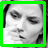

1/1 [==============================] - 0s 19ms/step
31
(31, 12, 12, 256)
18831.24
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 16, 17, 27]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 16, 17, 27]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 17, 18, 27]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 17, 18, 27]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 18, 25, 26, 27]
[0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 29, 30]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 16, 17, 18, 27]
[0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 16, 17, 27]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 17, 27]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 17, 18, 27]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 17, 18, 19, 25, 26, 27]
[5, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 28, 29, 30]
[5, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 28, 29, 30]
[5, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 28, 29, 30]
[5, 11, 12, 13, 14, 15, 16, 19, 20, 21, 22, 23, 24, 25, 26, 28, 29, 30]
[11, 12, 13, 14, 15, 16

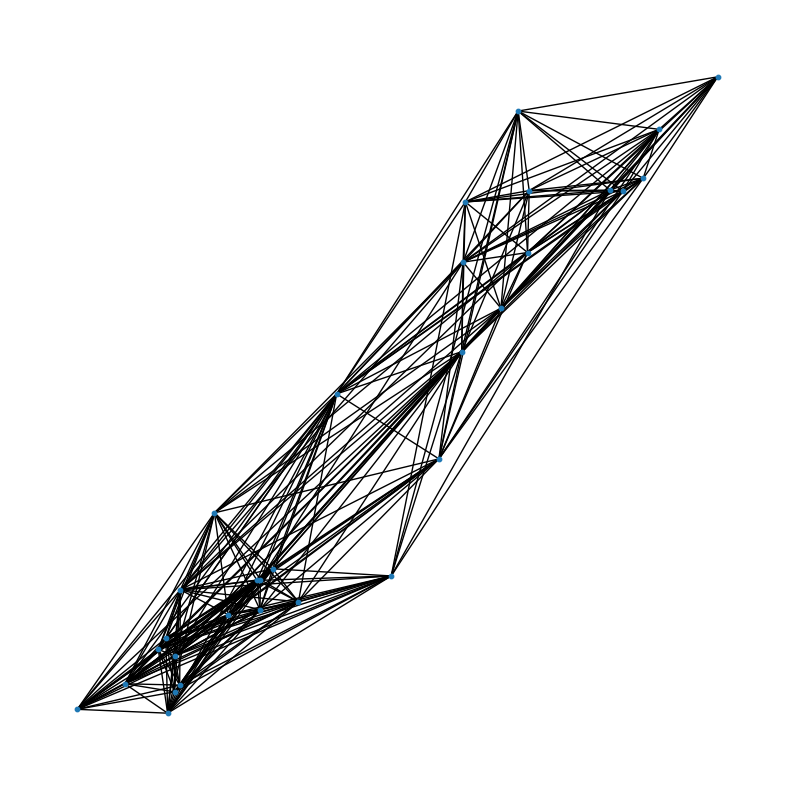

(48, 48, 1)
Rectangles:  [[ 1  2 43 43]]


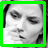

1/1 [==============================] - 0s 27ms/step
31
(31, 12, 12, 256)
18831.24
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 16, 17, 27]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 16, 17, 18, 27]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 17, 18, 27]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 17, 18, 27]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 17, 18, 25, 26, 27]
[0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 29, 30]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 16, 17, 18, 27]
[0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 16, 17, 27]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 17, 27]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 17, 18, 27]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 17, 18, 19, 25, 26, 27]
[5, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 28, 29, 30]
[5, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 28, 29, 30]
[5, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 28, 29, 30]
[5, 11, 12, 13, 14, 15, 16, 19, 20, 21, 22, 23, 24, 25, 26, 28, 29, 30]
[11, 12, 13, 14

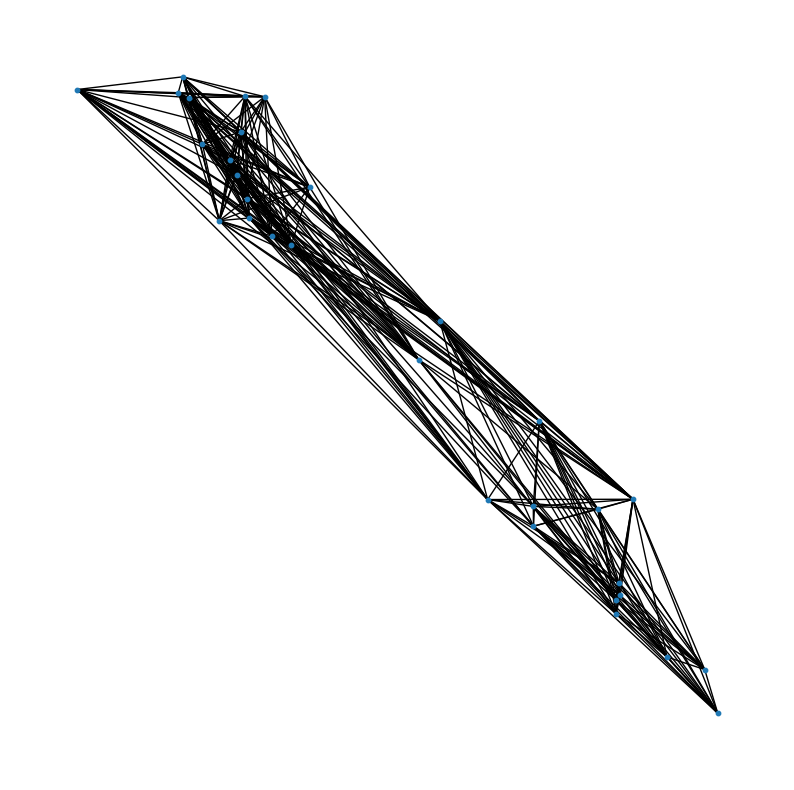

Optimal max_dist: 21000


In [ ]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import spectral_clustering

# Define a range of max_dist values to try
max_dists = [20900, 21000 ]

# Evaluate the performance of each value of max_dist using the silhouette score
scores = []
for max_dist in max_dists:
    adj = extract_features(img_array[0], predictor, face_cascade, landmark_indices, max_dist)
    labels = spectral_clustering(adj, n_clusters=2)
    score = silhouette_score(adj, labels)
    scores.append(score)

# Find the optimal value of max_dist
optimal_max_dist = max_dists[scores.index(max(scores))]
print("Optimal max_dist:", optimal_max_dist)

In [ ]:
len(landmarks)

1

In [ ]:
for landmarks_obj in landmarks:
    num_parts = landmarks_obj.num_parts
    print('Number of parts for this object:', num_parts)

Number of parts for this object: 31


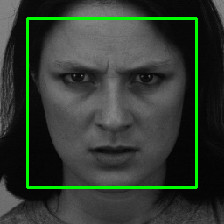

In [ ]:
from google.colab.patches import cv2_imshow
for (x, y, w, h) in rects:
    cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)

cv2_imshow(img)

In [ ]:
node_embeddings.shape

(31, 12, 12, 256)